In [1]:
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, learning_curve, GridSearchCV, train_test_split, validation_curve
from sklearn.metrics import f1_score, accuracy_score, log_loss
from collections import Counter
from io import StringIO
import sys
import matplotlib.pyplot as plt
import numpy as np
import time
import warnings
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

np.random.seed(0)
folds_num = 10
random_state = 7


def create_iteration_learning_curve(clf, X_train, X_test, Y_train, Y_test, title, loss=True, epochs = 2000):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []
    for i in range(epochs):
        clf.fit(X_train, Y_train)
        if (loss == True):
            y_pred_train = clf.predict_proba(X_train)
            train_loss.append(log_loss(Y_train, y_pred_train, labels=np.sort(np.unique(Y_train))))
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        if (loss == True):
            y_pred_proba = clf.predict_proba(X_test)
            test_loss.append(log_loss(Y_test, y_pred_proba, labels=np.sort(np.unique(Y_test))))
        test_scores.append(f1_score(Y_test, y_pred_test, average='micro'))
        train_scores.append(f1_score(Y_train, y_pred_train, average='micro'))
    
    if (loss == True):    
        fig, ax = plt.subplots()
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Loss")
        ax.set_title("Loss vs iterations for training and testing sets")
        ax.plot(range(epochs), train_loss, marker='o', label="Training loss",
                drawstyle="steps-post")
        ax.plot(range(epochs), test_loss, marker='o', label="Cross-validation loss",
                drawstyle="steps-post")
        ax.legend()

        plt.show()

    fig, ax = plt.subplots()
    ax.set_xlabel("Iterations")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs iterations for training and testing sets")
    ax.plot(range(epochs), train_scores, marker='o', label="train",
            drawstyle="steps-post")
    ax.plot(range(epochs), test_scores, marker='o', label="test",
            drawstyle="steps-post")
    ax.legend()
    
    plt.show()

        
    
def create_learning_curve(clf, x, y, title, train_sizes=np.linspace(.1, 1.0, 10)):
    kf = StratifiedKFold(n_splits=folds_num, random_state=random_state, shuffle=True)
    train_sizes_abs, train_scores, test_scores, fit_times, score_times = learning_curve(clf, x, y, cv=kf, train_sizes=train_sizes, n_jobs=-1, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    score_times_mean = np.mean(score_times, axis=1)
    score_times_std = np.std(score_times, axis=1)
    
    _, axes = plt.subplots(2, 1, figsize=(10, 15))

    axes[0].set_title(title)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    
    axes[0].grid()
    axes[0].fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes_abs, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes_abs, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes_abs, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes_abs, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1, color='r')
    axes[1].fill_between(train_sizes_abs, score_times_mean - score_times_std,
                         score_times_mean + score_times_std, alpha=0.1, color='g')
    axes[1].plot(train_sizes_abs, fit_times_mean, 'o-', color="r",
                 label="Fit Time")
    axes[1].plot(train_sizes_abs, score_times_mean, 'o-', color="g",
                 label="Score time")
    axes[1].legend(loc="best")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    plt.show()
    
def plot_grid_search(clf, name, title, X_train, X_test, Y_train, Y_test, param_name, param_range):
    train_scores = []
    test_scores = []
    clfs = []
    for param in param_range:
        param_obj = {param_name: param}
        clf.set_params(**param_obj)
        clf.fit(X_train, Y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        test_scores.append(f1_score(Y_test, y_pred_test, average='micro'))
        train_scores.append(f1_score(Y_train, y_pred_train, average='micro'))

    fig, ax = plt.subplots()
    ax.set_xlabel(name)
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs " + name + " for training and testing sets")
    ax.plot(param_range, train_scores, marker='o', label="train",
            drawstyle="steps-post")
    ax.plot(param_range, test_scores, marker='o', label="test",
            drawstyle="steps-post")
    ax.legend()
    
    plt.show()
    
def plot_accuracy_time_comparison(train_times, test_times, accuracies):
    classifiers = ['Decision Tree', 'Boosting', 'Neural Network', 'SVM', 'kNN']

    _, axes = plt.subplots(3, 1, figsize=(10, 15))

    axes[0].set_title('Training Time Comparison')
    axes[0].set_ylabel("Training method")
    axes[0].set_xlabel("Training Time")
    
    axes[0].grid()
    axes[0].barh(classifiers, train_times)
    axes[0].legend(loc="best")

    axes[1].set_title('Test Time Comparison')
    axes[1].set_ylabel("Training method")
    axes[1].set_xlabel("Test Time")
    
    axes[1].grid()
    axes[1].barh(classifiers, test_times)
    axes[1].legend(loc="best")
    
    axes[2].set_title('Accuracy Comparison')
    axes[2].set_ylabel("Training method")
    axes[2].set_xlabel("Testing Accuracy")
    
    axes[2].grid()
    axes[2].barh(classifiers, accuracies)
    axes[2].legend(loc="best")

    plt.show()

def get_grid_search_params(clf, X, y, param_grid):
    kf = StratifiedKFold(n_splits=folds_num, random_state=random_state, shuffle=True)
    gscv = GridSearchCV(clf, cv=kf, param_grid=param_grid,scoring='f1_micro',n_jobs=-1)
    gscv.fit(X,y)
    return gscv.best_params_

In [2]:

def classify_decision_tree(X_train, X_test, Y_train, Y_test):
    clf = tree.DecisionTreeClassifier(random_state=random_state)
    max_depth_range = np.arange(1,30)
    param_grid = {'max_depth': max_depth_range}
    params = get_grid_search_params(clf, X_train, Y_train, param_grid)
    plot_grid_search(
        tree.DecisionTreeClassifier(random_state=random_state),
        'Max Depth',
        'Grid Search Score',
        X_train, X_test, Y_train, Y_test,
        'max_depth',
        max_depth_range
    )
    max_depth = params['max_depth']
    
    clf = tree.DecisionTreeClassifier(random_state=random_state,max_depth=max_depth)
    criterion_range = ['gini', 'entropy']
    param_grid = {'criterion': criterion_range}    
    params = get_grid_search_params(clf, X_train, Y_train, param_grid)   
    plot_grid_search(
        tree.DecisionTreeClassifier(random_state=random_state),
        'Criterion',
        'Grid Search Score',
        X_train, X_test, Y_train, Y_test,
        'criterion',
        criterion_range
    )
    criterion = params['criterion']
    
    clf = tree.DecisionTreeClassifier(random_state=random_state,criterion=criterion,max_depth=max_depth)
    min_samples_leaf_range = np.linspace(1,200,50).round().astype('int')
    param_grid = {'min_samples_leaf': min_samples_leaf_range}
    params = get_grid_search_params(clf, X_train, Y_train, param_grid)
    plot_grid_search(
        tree.DecisionTreeClassifier(random_state=random_state, criterion=criterion,max_depth=max_depth),
        'Min Sample Leaf',
        'Grid Search Score',
        X_train, X_test, Y_train, Y_test,
        'min_samples_leaf',
        min_samples_leaf_range
    )
    min_samples_leaf = params['min_samples_leaf']

    clf = tree.DecisionTreeClassifier(random_state=random_state, criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    
    path = clf.cost_complexity_pruning_path(X_train, Y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    ccp_alphas = np.sort(ccp_alphas)
    print(len(ccp_alphas))
    ccp_alphas = ccp_alphas[0:min(200, len(ccp_alphas))]
    
    print(len(ccp_alphas))

    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = tree.DecisionTreeClassifier(random_state=random_state, criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, ccp_alpha=ccp_alpha)
        clf.fit(X_train, Y_train)
        clfs.append(clf)
    clfs = clfs[:-1]
    ccp_alphas = ccp_alphas[:-1]

    train_scores = [clf.score(X_train, Y_train) for clf in clfs]
    test_scores = [clf.score(X_test, Y_test) for clf in clfs]

    fig, ax = plt.subplots()
    ax.set_xlabel("alpha")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs alpha for training and testing sets")
    ax.plot(ccp_alphas, train_scores, marker='o', label="train",
            drawstyle="steps-post")
    ax.plot(ccp_alphas, test_scores, marker='o', label="test",
            drawstyle="steps-post")
    ax.legend()
    
    plt.show()
    
    return ccp_alphas, criterion, max_depth, min_samples_leaf

In [3]:
from sklearn.neural_network import MLPClassifier
def classify_neural_network(X_train, X_test, Y_train, Y_test, epochs=500):
    clf = MLPClassifier(random_state=random_state, activation='logistic',max_iter=epochs)
    hidden_sizes = [1,3,5,7,10,15,20,25,30,35,40,50,60,70,80,100]
    param_grid = {'hidden_layer_sizes': hidden_sizes}
    plot_grid_search(
        MLPClassifier(random_state=random_state, activation='logistic',max_iter=epochs),
        'Hidden Layer Size',
        'Grid Search Score',
        X_train, X_test, Y_train, Y_test,
        'hidden_layer_sizes',
        hidden_sizes
    )
    params = get_grid_search_params(clf, X_train, Y_train, param_grid)
    hidden_layer_sizes = params['hidden_layer_sizes']
    
    clf = MLPClassifier(random_state=random_state, activation='logistic',hidden_layer_sizes=hidden_layer_sizes,max_iter=epochs)
    lr_rates = [0.0001,0.0005,0.001,0.005,0.01,0.05]
    param_grid = {'learning_rate_init': lr_rates}
    plot_grid_search(
        MLPClassifier(random_state=random_state, activation='logistic',hidden_layer_sizes=hidden_layer_sizes,max_iter=epochs),
        'Learning Rate',
        'Grid Search Score',
        X_train, X_test, Y_train, Y_test,
        'learning_rate_init',
        lr_rates
    )
    params = get_grid_search_params(clf, X_train, Y_train, param_grid)
    learning_rate_init = params['learning_rate_init']
    
    clf = MLPClassifier(random_state=random_state, activation='logistic', hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=learning_rate_init,max_iter=1,warm_start=True)
    create_iteration_learning_curve(clf, X_train, X_test, Y_train, Y_test, 'Neural Network validation tree', True, epochs)
    
    clf = MLPClassifier(random_state=random_state, activation='logistic', hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=learning_rate_init,max_iter=epochs)
    create_learning_curve(clf, X_train, Y_train, 'Neural Network validation tree')
    
    return MLPClassifier(random_state=random_state, activation='logistic', hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=learning_rate_init,max_iter=epochs), hidden_layer_sizes, learning_rate_init

In [4]:
from sklearn.ensemble import AdaBoostClassifier
def classify_boosted_learner(clf, X_train, X_test, Y_train, Y_test):
    n_estimators_range = np.arange(50, 250, 25)
    plot_grid_search(
        AdaBoostClassifier(base_estimator=clf, random_state=random_state),
        'No Of Estimators',
        'Grid Search Score',
        X_train, X_test, Y_train, Y_test,
        'n_estimators',
        n_estimators_range
    )
    aclf = AdaBoostClassifier(base_estimator=clf, random_state=random_state)
    param_grid = {'n_estimators': n_estimators_range}
    params = get_grid_search_params(aclf, X_train, Y_train, param_grid)
    n_estimators = params['n_estimators']
    
    lr_rates_range = [0.0001,0.0005,0.001,0.005,0.01,0.05, 0.1, 0.3, 0.5, 0.7, 1.0]
    plot_grid_search(
        AdaBoostClassifier(base_estimator=clf, random_state=random_state, n_estimators=n_estimators),
        'Learning Rate',
        'Grid Search Score',
        X_train, X_test, Y_train, Y_test,
        'learning_rate',
        lr_rates_range
    )
    aclf = AdaBoostClassifier(base_estimator=clf, random_state=random_state, n_estimators=n_estimators)
    param_grid = {'learning_rate': lr_rates_range}
    params = get_grid_search_params(aclf, X_train, Y_train, param_grid)
    learning_rate = params['learning_rate']
    
    
    clf = AdaBoostClassifier(base_estimator=clf, random_state=random_state, n_estimators=n_estimators, learning_rate=learning_rate)
    create_learning_curve(clf, X_train, Y_train, 'Boosting validation')
    return AdaBoostClassifier(base_estimator=clf, random_state=random_state, n_estimators=n_estimators, learning_rate=learning_rate), n_estimators, learning_rate

In [5]:
from sklearn.linear_model import SGDClassifier
def classify_svm_learner(X_train, X_test, Y_train, Y_test):
    
    clf = SGDClassifier(random_state=random_state,n_jobs=-1,loss="modified_huber")
    alpha_range = np.linspace(0.001, 1, 50)
    param_grid = {'alpha': alpha_range}
    plot_grid_search(
        SGDClassifier(random_state=random_state,n_jobs=-1,loss="modified_huber"),
        'alpha',
        'Grid Search Score',
        X_train, X_test, Y_train, Y_test,
        'alpha',
        alpha_range
    )
    params = get_grid_search_params(clf, X_train, Y_train, param_grid)
    alpha=params['alpha']
    
    
    
    clf = SGDClassifier(random_state=random_state,alpha=alpha,n_jobs=-1, learning_rate='constant',eta0=0.1,loss="modified_huber")
    eta_range = [0.0001,0.0003, 0.0005, 0.0007, 0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05]
    param_grid = {'eta0': eta_range}
    plot_grid_search(
         SGDClassifier(random_state=random_state, alpha=alpha,n_jobs=-1, learning_rate='constant',eta0=0.1,loss="modified_huber"),
        'Learning Rate',
        'Grid Search Score',
        X_train, X_test, Y_train, Y_test,
        'eta0',
        eta_range
    )
    params = get_grid_search_params(clf, X_train, Y_train, param_grid)
    eta0=params['eta0']
    
    clf = SGDClassifier(random_state=random_state, alpha=alpha, eta0=eta0,n_jobs=-1, learning_rate='constant',warm_start=True,max_iter=1,loss="modified_huber")
    create_iteration_learning_curve(clf, X_train, X_test, Y_train, Y_test, 'SVM validation tree', True)
    
    clf = SGDClassifier(random_state=random_state, alpha=alpha, eta0=eta0,n_jobs=-1, learning_rate='constant',loss="modified_huber")
    create_learning_curve(clf, X_train, Y_train, 'SVM learner validation')
    
    return SGDClassifier(random_state=random_state, alpha=alpha, eta0=eta0,n_jobs=-1, learning_rate='constant',loss="modified_huber"), alpha, eta0

In [6]:
from sklearn.neighbors import KNeighborsClassifier
def classify_kNN_learner(X_train, X_test, Y_train, Y_test):
    clf = KNeighborsClassifier(n_jobs=-1)
    metric_range = ['manhattan', 'euclidean', 'minkowski']
    param_grid = {'metric': metric_range}
    plot_grid_search(
        KNeighborsClassifier(n_jobs=-1),
        'Metric',
        'Grid Search Score',
        X_train, X_test, Y_train, Y_test,
        'metric',
        metric_range
    )
    params = get_grid_search_params(clf, X_train, Y_train, param_grid)
    metric=params['metric']
    
    
    
    clf = KNeighborsClassifier(n_jobs=-1, metric=metric)
    n_neighbors_range = np.arange(1, 25, 1)
    param_grid = {'n_neighbors': n_neighbors_range}
    plot_grid_search(
        KNeighborsClassifier(n_jobs=-1, metric=metric),
        'Neighbors',
        'Grid Search Score',
        X_train, X_test, Y_train, Y_test,
        'n_neighbors',
        n_neighbors_range
    )
    params = get_grid_search_params(clf, X_train, Y_train, param_grid)
    n_neighbors=params['n_neighbors']
    
    
    clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=n_neighbors, metric=metric)
    create_learning_curve(clf, X_train, Y_train, 'kNN learner validation')
    return KNeighborsClassifier(n_jobs=-1, n_neighbors=n_neighbors, metric=metric), metric, n_neighbors

In [7]:
def get_time_accuracy(clf, X_train, X_test, Y_train, Y_test):
    train0 = time.time()
    clf.fit(X_train, Y_train)
    train1 = time.time()
    
    test0 = time.time()
    y_pred = clf.predict(X_test)
    test1 = time.time()
    
    score = f1_score(Y_test, y_pred, average='micro')
    
    return train1 - train0, test1 - test0, score

In [9]:
def return_car_transform(df):
    def trasform_high_to_int(value):
        if (value == 'vhigh'):
            return 1
        elif (value == 'high' or value == 'big'):
            return 2
        elif (value == 'med'):
            return 3
        elif (value == 'low' or value == 'small'):
            return 4

    def transform_more_to_int(value):
        if (value == '5more' or value == 'more'):
            return 5
        else:
            return int(value)

    def car_status_to_int(value):
        if (value == 'unacc'):
            return 1
        elif (value == 'acc'):
            return 2
        elif(value == 'good'):
            return 3
        elif(value == 'vgood'):
            return 4

    df['buying'] = df['buying'].transform(lambda x: trasform_high_to_int(x))
    df['maint'] = df['maint'].transform(lambda x: trasform_high_to_int(x))
    df['lug_boot'] = df['lug_boot'].transform(lambda x: trasform_high_to_int(x))
    df['safety'] = df['safety'].transform(lambda x: trasform_high_to_int(x))
    df['doors'] = df['doors'].transform(lambda x: transform_more_to_int(x))
    df['persons'] = df['persons'].transform(lambda x: transform_more_to_int(x))
    df['car_status'] = df['car_status'].transform(lambda x: car_status_to_int(x))
    
    return df

car_status
1             1210
2              384
3               69
4               65
dtype: int64


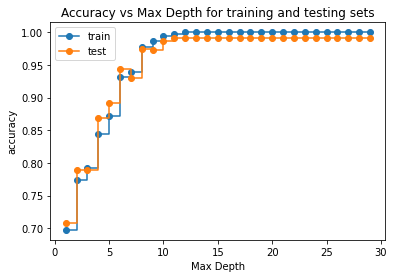

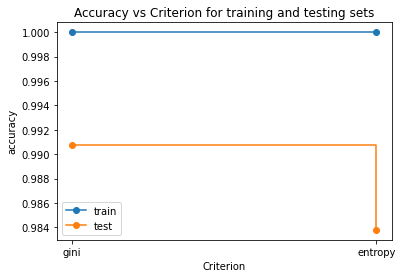

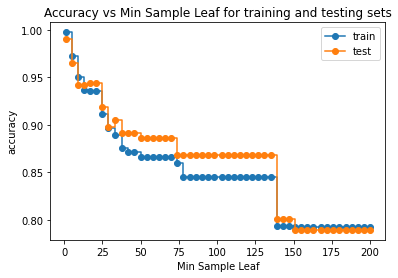

39
39


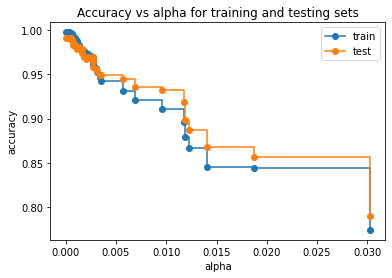

Decision tree ccp_alpha: 0.0003000685871056241, criterion: gini, max_depth: 11, min_samples_leaf: 1


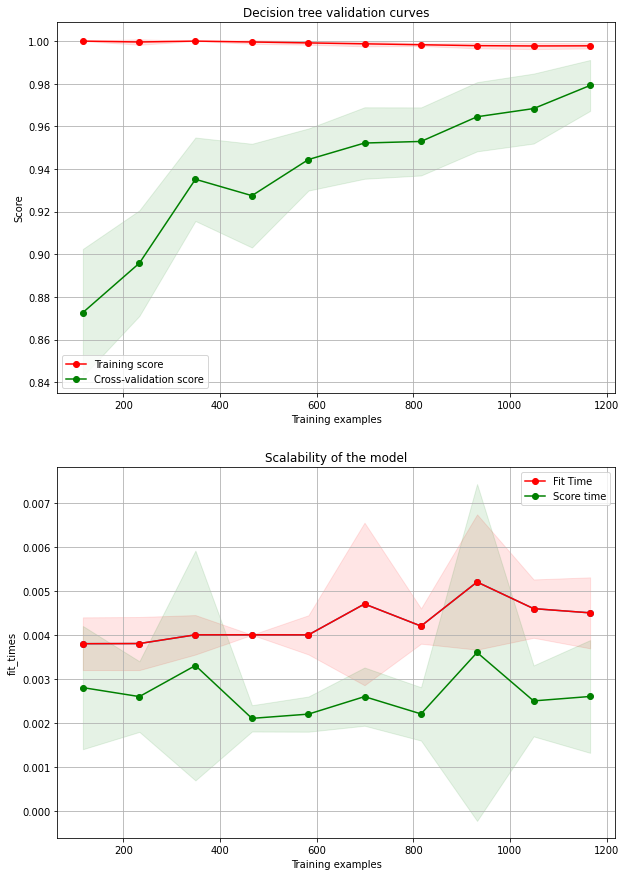

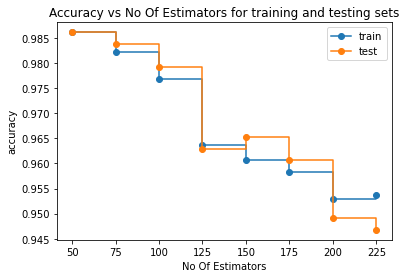

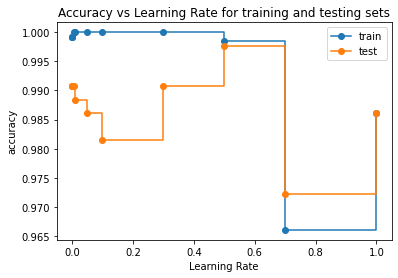

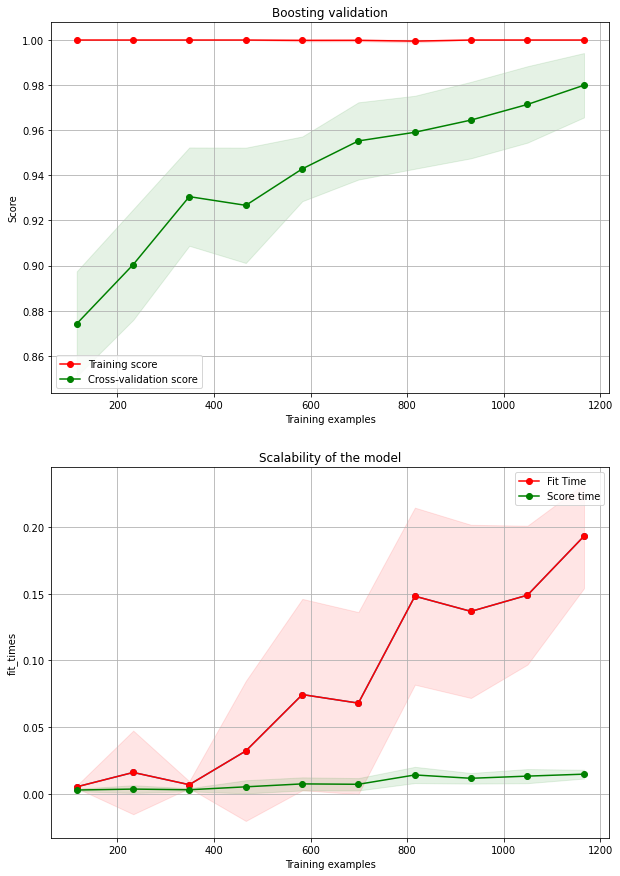

Boosted Learner n_estimators: 50, learning_rate: 0.001


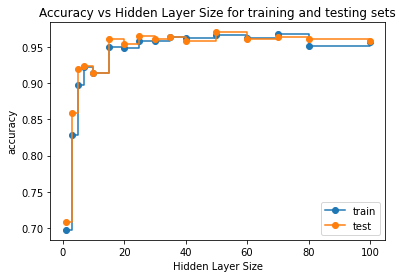

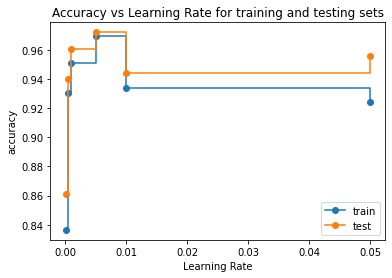

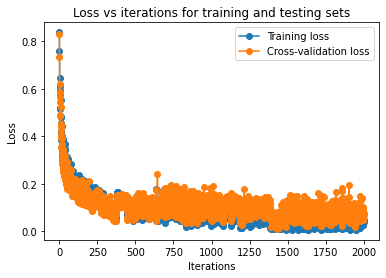

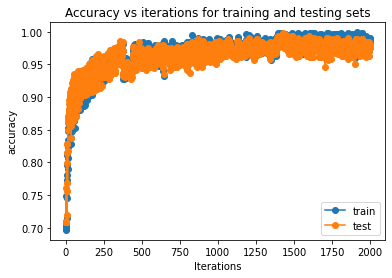

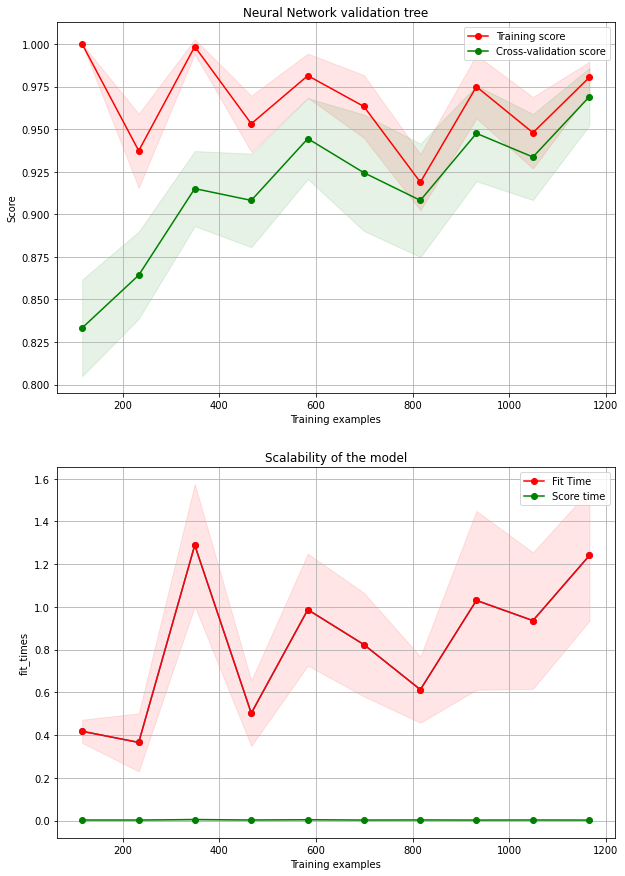

Neural Network hidden_layer_sizes: 80, learning_rate_init: 0.05


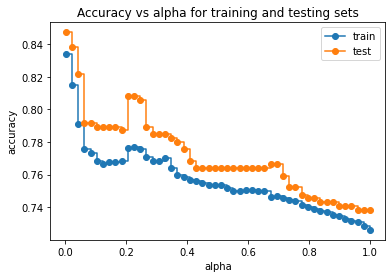

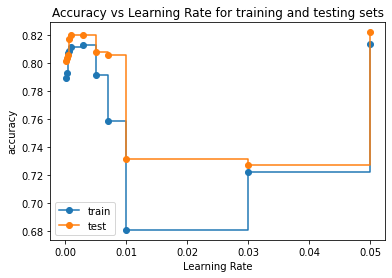

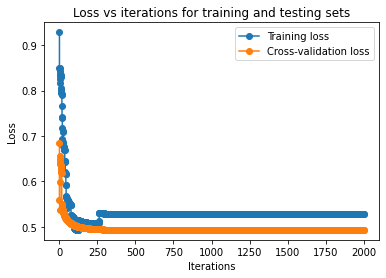

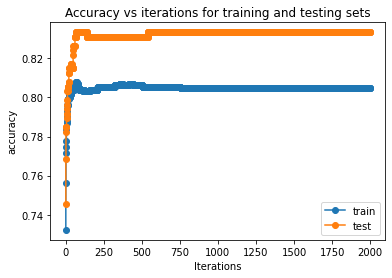

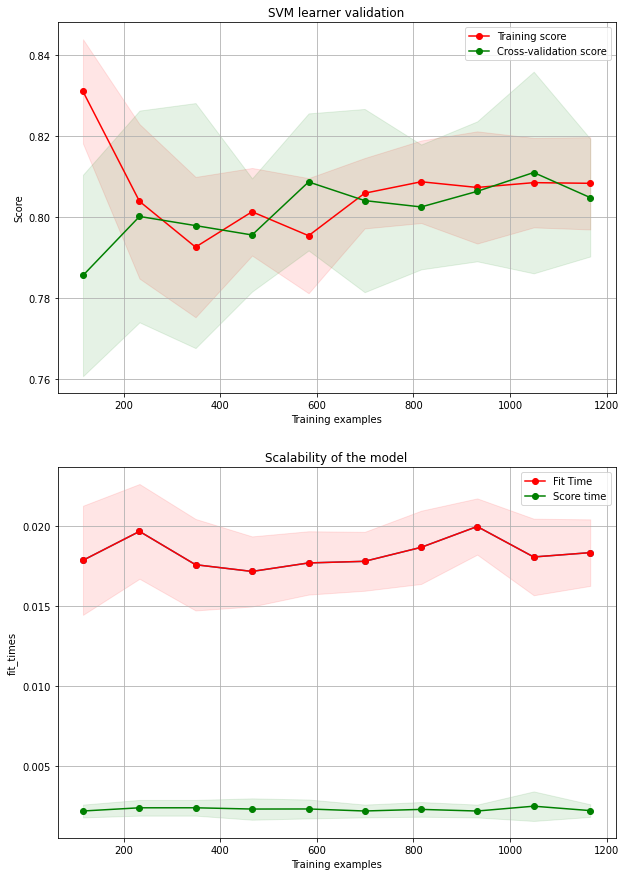

SVM alpha: 0.001, Learning rate: 0.001


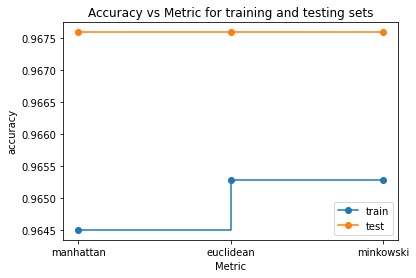

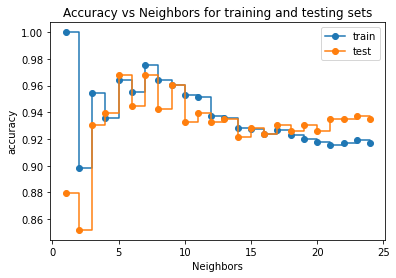

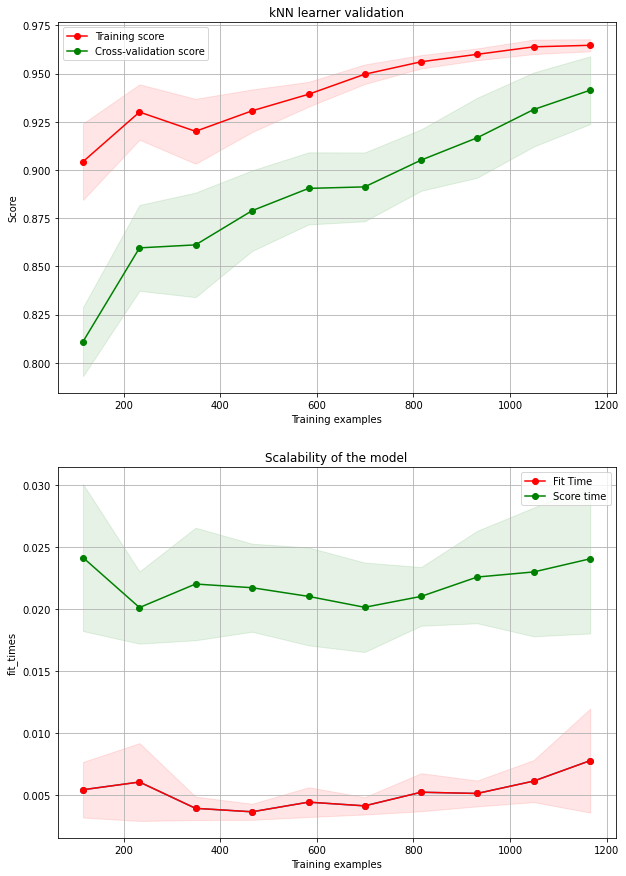

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


kNN metric: manhattan, n_neighbors: 5


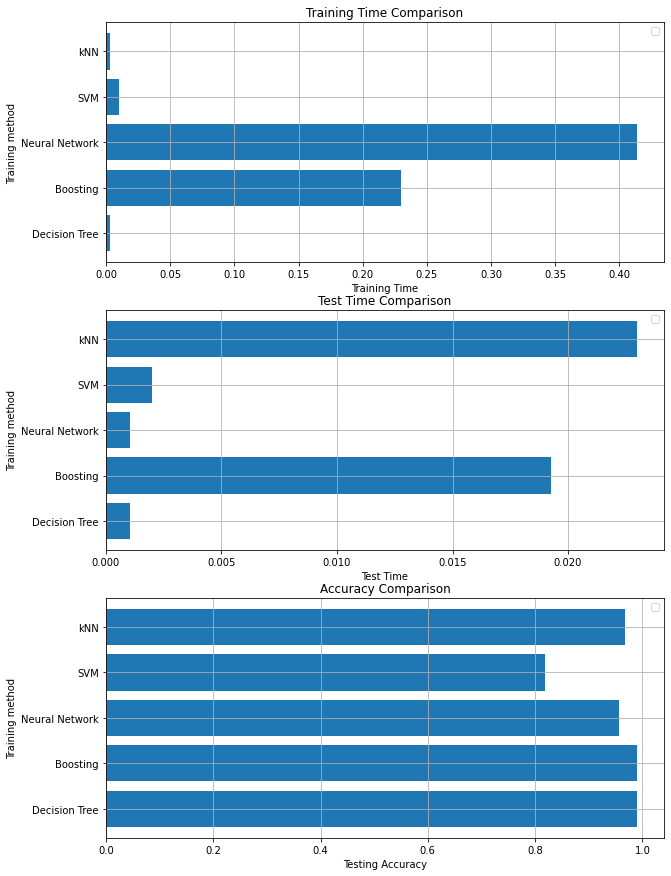

In [10]:
def run_car_data_original_classifier():
    train_times = np.empty(5)
    test_times = np.empty(5)
    accuracy = np.empty(5)
    df = pd.read_csv('car.csv', delimiter=',')
    df = return_car_transform(df)
    X = df[['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']]
    y = df[['car_status']].values.ravel()
    
    print(df[['car_status']].value_counts())
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=random_state, shuffle=True)
    
    # Decision Tree
    ccp_alphas, criterion, max_depth, min_samples_leaf = classify_decision_tree(X_train, X_test, Y_train, Y_test)
    print("Decision tree ccp_alpha: " + str(ccp_alphas[2]) + ", criterion: " + str(criterion) + ", max_depth: " + str(max_depth) + ", min_samples_leaf: " + str(min_samples_leaf))
    
    clf = tree.DecisionTreeClassifier(random_state=random_state, criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, ccp_alpha=ccp_alphas[2])
    create_learning_curve(clf, X_train, Y_train, "Decision tree validation curves")
    clf = tree.DecisionTreeClassifier(random_state=random_state, criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, ccp_alpha=ccp_alphas[2])
    train_times[0], test_times[0], accuracy[0] = get_time_accuracy(clf,  X_train, X_test, Y_train, Y_test)
    
    # Boosting
    dclf = tree.DecisionTreeClassifier(random_state=random_state, criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, ccp_alpha=ccp_alphas[2])
    clf, n_estimators, learning_rate = classify_boosted_learner(dclf, X_train, X_test, Y_train, Y_test)
    train_times[1], test_times[1], accuracy[1] = get_time_accuracy(clf,  X_train, X_test, Y_train, Y_test)
    
    print("Boosted Learner n_estimators: " + str(n_estimators) + ", learning_rate: " + str(learning_rate))
    
    # Neural Network
    clf, hidden_layer_sizes, learning_rate_init = classify_neural_network(X_train, X_test, Y_train, Y_test, 2000)
    train_times[2], test_times[2], accuracy[2] = get_time_accuracy(clf,  X_train, X_test, Y_train, Y_test)
    
    print("Neural Network hidden_layer_sizes: " + str(hidden_layer_sizes) + ", learning_rate_init: " + str(learning_rate_init))
    
    # SVM
    clf, alpha, eta0 = classify_svm_learner(X_train, X_test, Y_train, Y_test)
    train_times[3], test_times[3], accuracy[3] = get_time_accuracy(clf,  X_train, X_test, Y_train, Y_test)
    
    print("SVM alpha: " + str(alpha) + ", Learning rate: " + str(eta0))
    
    # kNN
    clf, metric, n_neighbors = classify_kNN_learner(X_train, X_test, Y_train, Y_test)
    train_times[4], test_times[4], accuracy[4] = get_time_accuracy(clf,  X_train, X_test, Y_train, Y_test)
    print("kNN metric: " + str(metric) + ", n_neighbors: " + str(n_neighbors))
    
    plot_accuracy_time_comparison(train_times, test_times, accuracy)

run_car_data_original_classifier()

Counter({1: 1210, 2: 384, 3: 69, 4: 65})
Counter({1: 1210, 2: 1210, 4: 1210, 3: 1210})


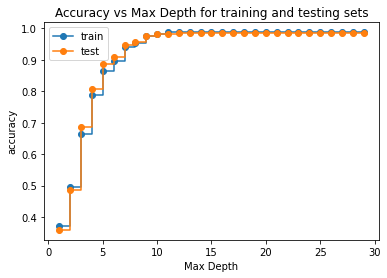

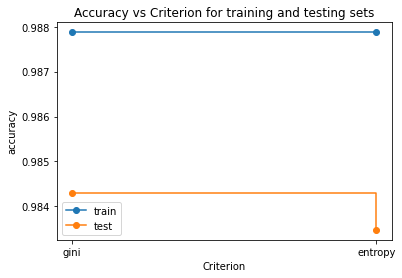

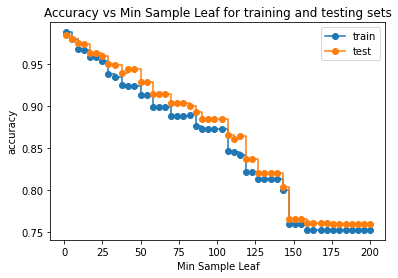

58
58


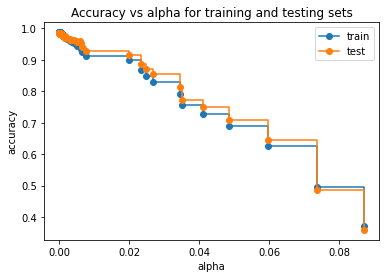

Decision tree ccp_alpha: 0.0, criterion: gini, max_depth: 12, min_samples_leaf: 1


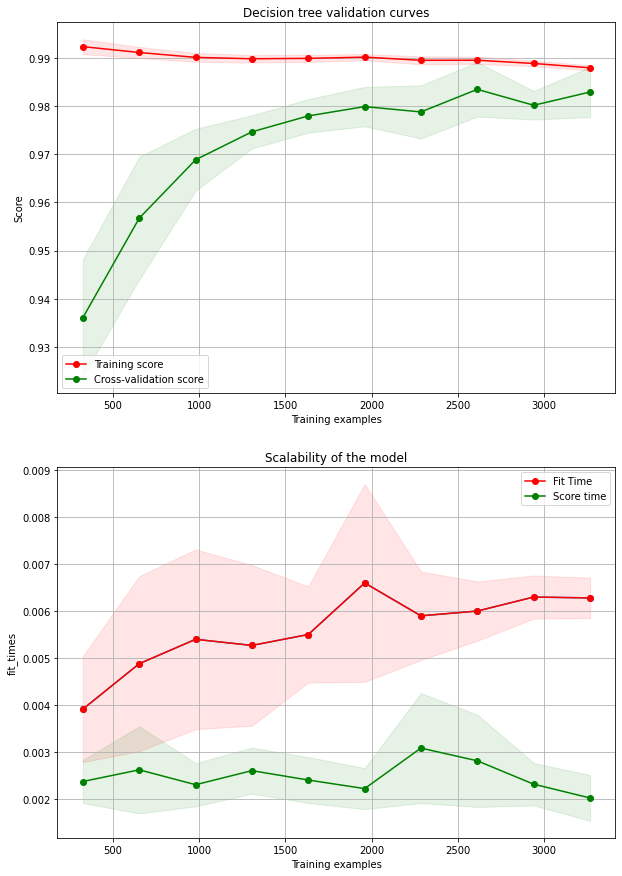

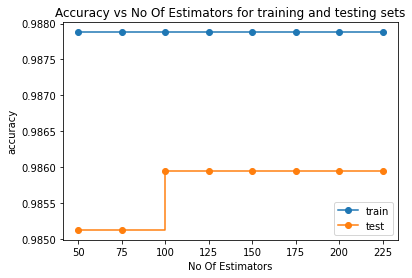

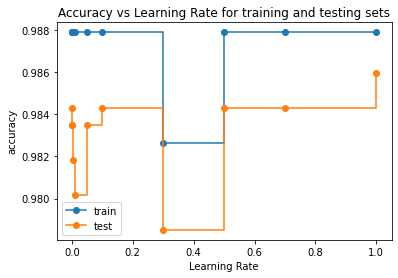

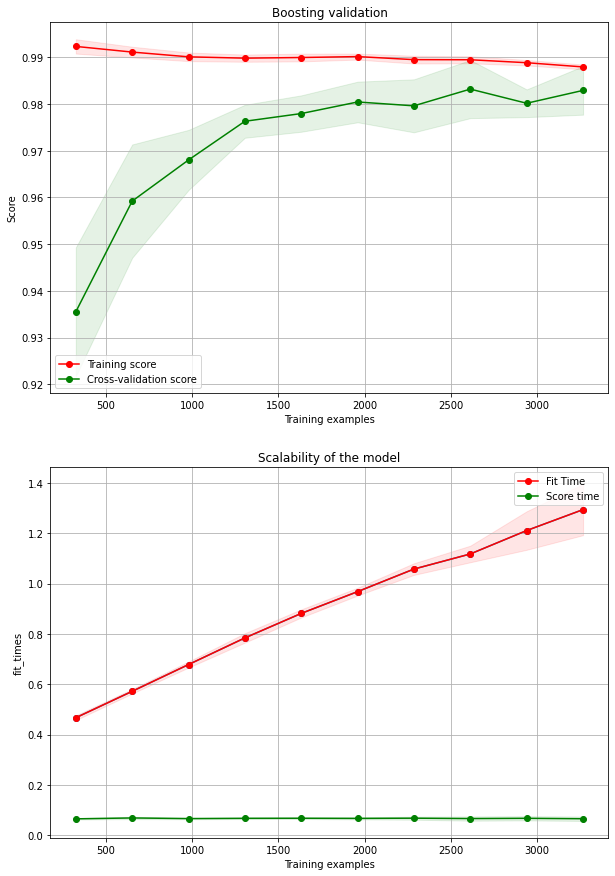

Boosted Learner n_estimators: 225, learning_rate: 0.0001


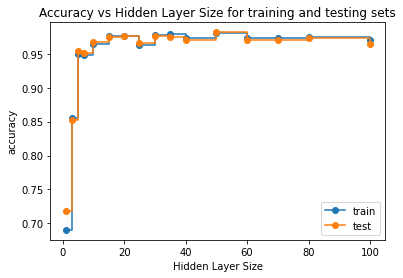

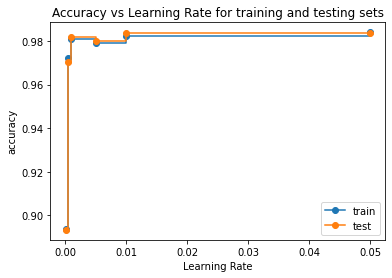

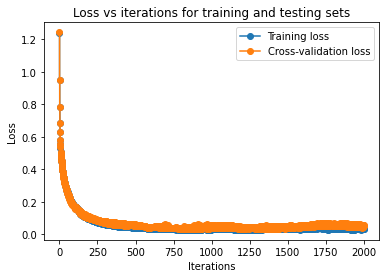

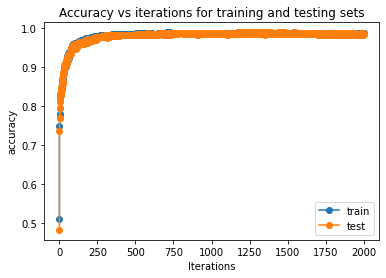

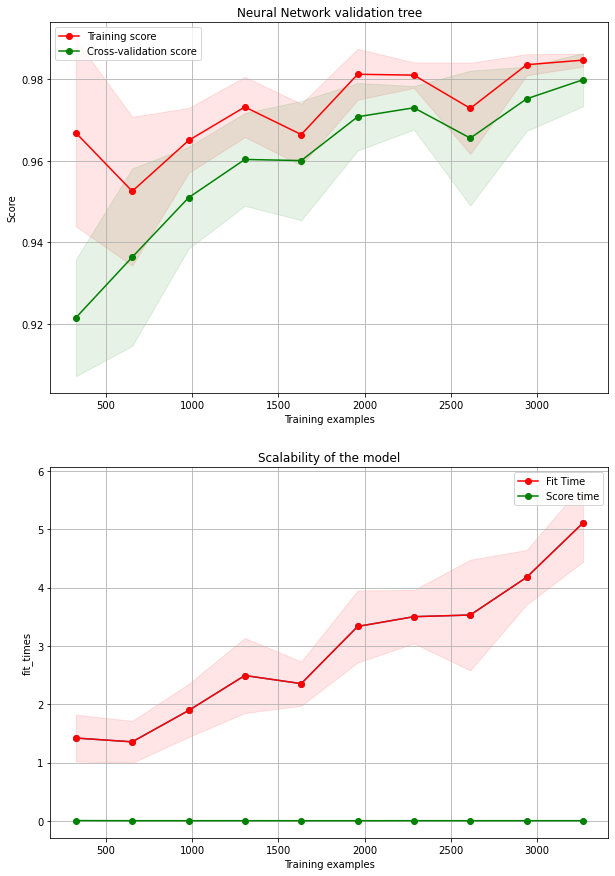

Neural Network hidden_layer_sizes: 50, learning_rate_init: 0.01


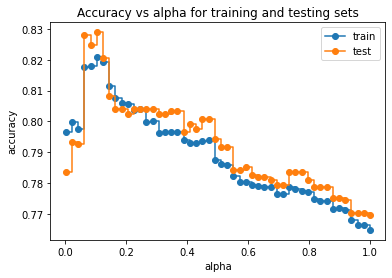

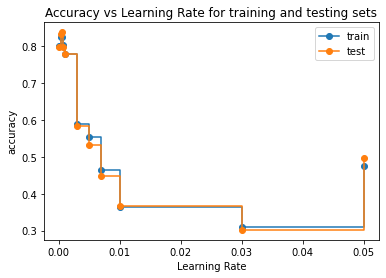

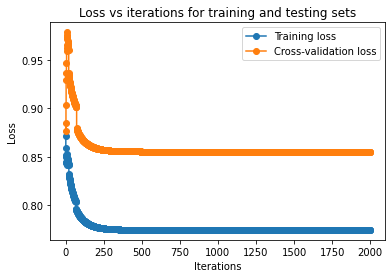

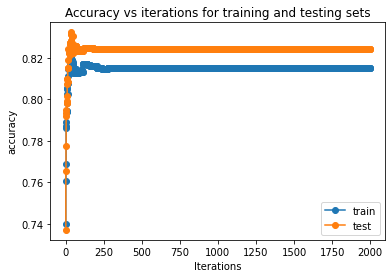

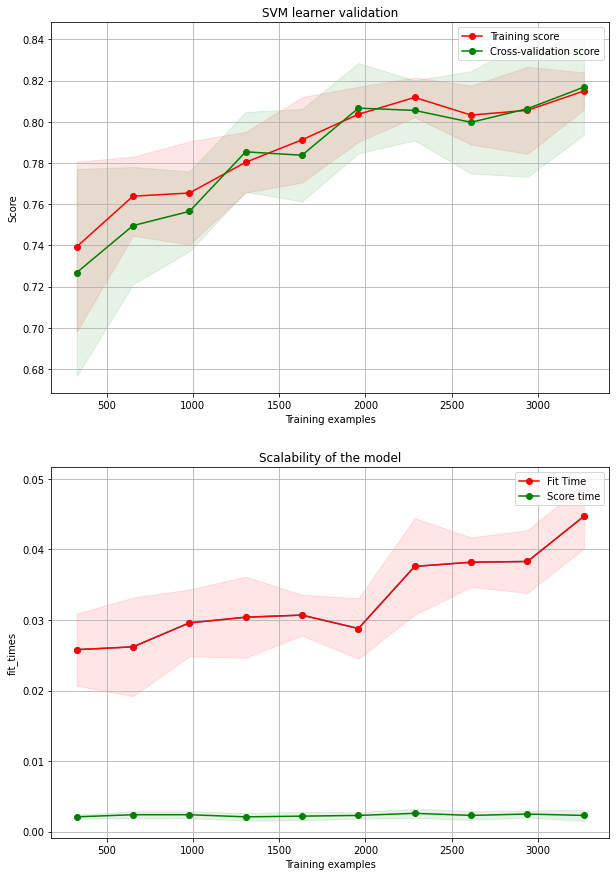

SVM alpha: 0.041775510204081635, Learning rate: 0.0005


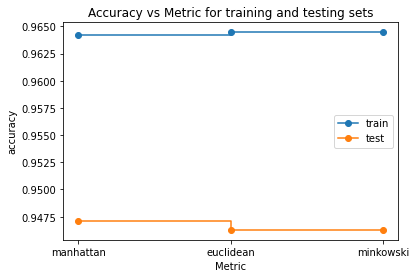

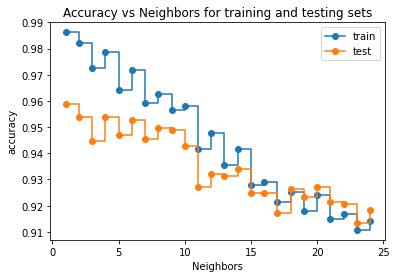

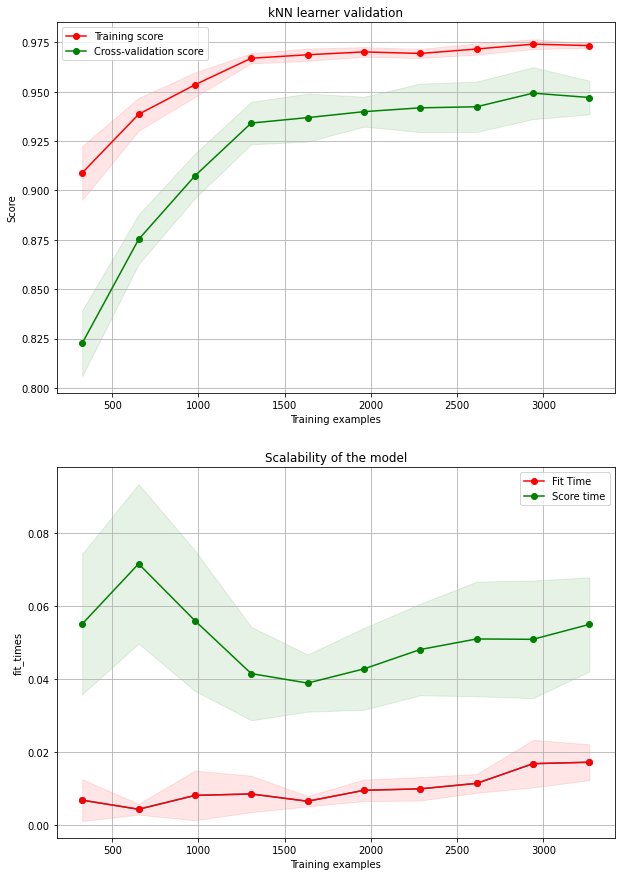

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


kNN metric: manhattan, n_neighbors: 4


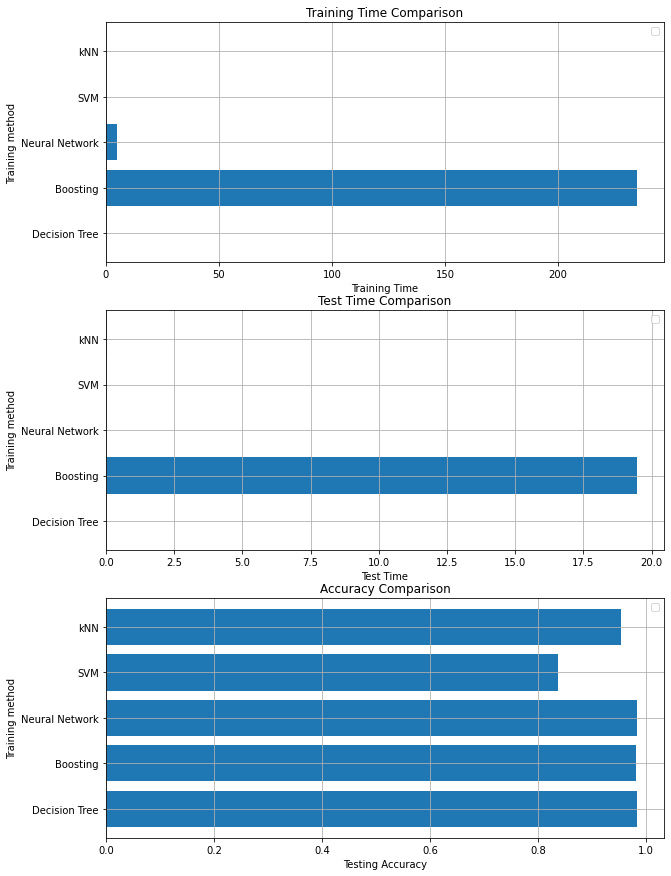

In [11]:
def run_car_data_classifier():
    train_times = np.empty(5)
    test_times = np.empty(5)
    accuracy = np.empty(5)
    df = pd.read_csv('car.csv', delimiter=',')
    df = return_car_transform(df)
    X = df[['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']]
    y = df[['car_status']].values.ravel()
    
    print(Counter(y))
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
    print(Counter(y))
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=random_state, shuffle=True)
    
    # Decision Tree
    ccp_alphas, criterion, max_depth, min_samples_leaf = classify_decision_tree(X_train, X_test, Y_train, Y_test)
    print("Decision tree ccp_alpha: " + str(ccp_alphas[0]) + ", criterion: " + str(criterion) + ", max_depth: " + str(max_depth) + ", min_samples_leaf: " + str(min_samples_leaf))
    
    clf = tree.DecisionTreeClassifier(random_state=random_state, criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, ccp_alpha=ccp_alphas[0])
    create_learning_curve(clf, X_train, Y_train, "Decision tree validation curves")
    clf = tree.DecisionTreeClassifier(random_state=random_state, criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, ccp_alpha=ccp_alphas[0])
    train_times[0], test_times[0], accuracy[0] = get_time_accuracy(clf,  X_train, X_test, Y_train, Y_test)
    
    # Boosting
    dclf = tree.DecisionTreeClassifier(random_state=random_state, criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, ccp_alpha=ccp_alphas[0])
    clf, n_estimators, learning_rate = classify_boosted_learner(dclf, X_train, X_test, Y_train, Y_test)
    train_times[1], test_times[1], accuracy[1] = get_time_accuracy(clf,  X_train, X_test, Y_train, Y_test)
    
    print("Boosted Learner n_estimators: " + str(n_estimators) + ", learning_rate: " + str(learning_rate))
    
    # Neural Network
    clf, hidden_layer_sizes, learning_rate_init = classify_neural_network(X_train, X_test, Y_train, Y_test, 2000)
    train_times[2], test_times[2], accuracy[2] = get_time_accuracy(clf,  X_train, X_test, Y_train, Y_test)
    
    print("Neural Network hidden_layer_sizes: " + str(hidden_layer_sizes) + ", learning_rate_init: " + str(learning_rate_init))
    
    # SVM
    clf, alpha, eta0 = classify_svm_learner(X_train, X_test, Y_train, Y_test)
    train_times[3], test_times[3], accuracy[3] = get_time_accuracy(clf,  X_train, X_test, Y_train, Y_test)
    
    print("SVM alpha: " + str(alpha) + ", Learning rate: " + str(eta0))
    
    # kNN
    clf, metric, n_neighbors = classify_kNN_learner(X_train, X_test, Y_train, Y_test)
    train_times[4], test_times[4], accuracy[4] = get_time_accuracy(clf,  X_train, X_test, Y_train, Y_test)
    print("kNN metric: " + str(metric) + ", n_neighbors: " + str(n_neighbors))
    
    plot_accuracy_time_comparison(train_times, test_times, accuracy)

run_car_data_classifier()

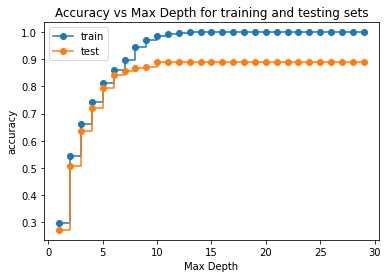

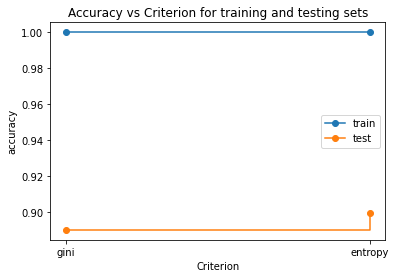

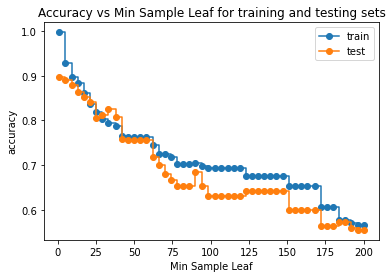

135
135


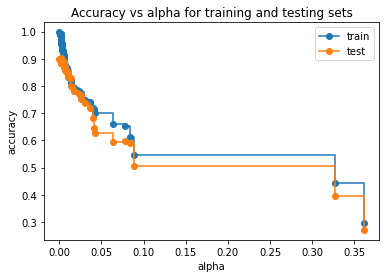

Decision tree ccp_alpha: 0.0, criterion: entropy, max_depth: 13, min_samples_leaf: 1


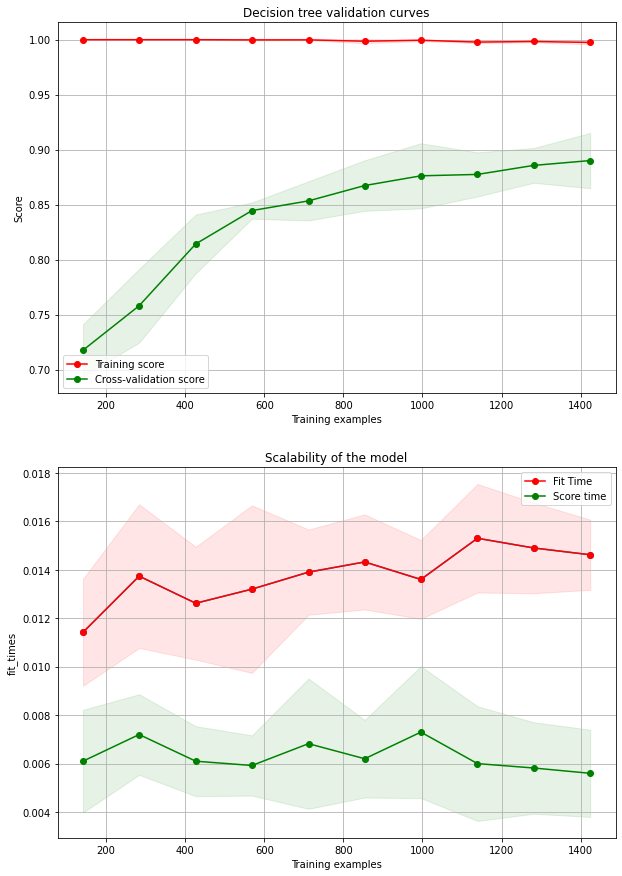

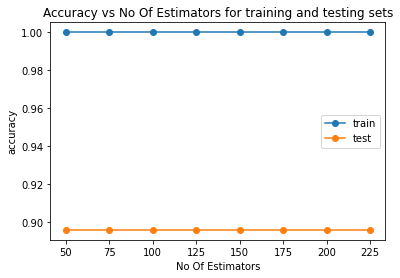

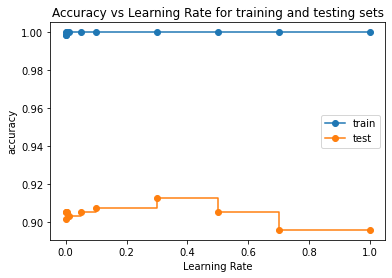

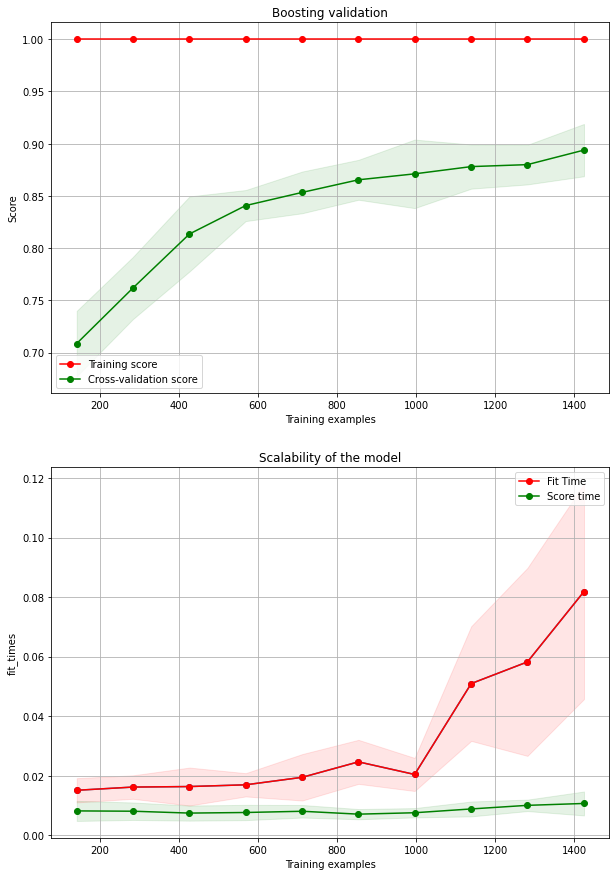

Boosted Learner n_estimators: 50, learning_rate: 0.05


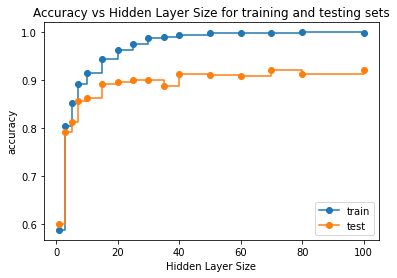

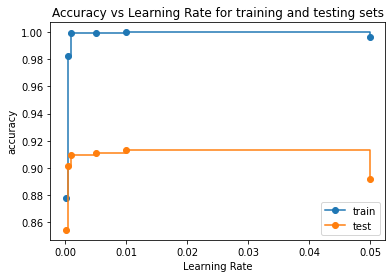

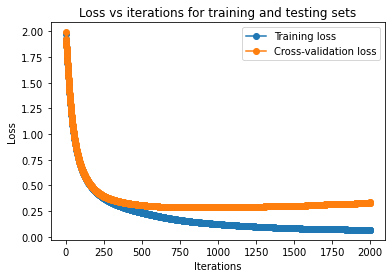

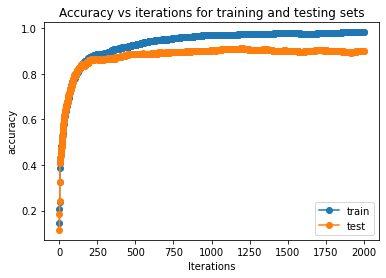

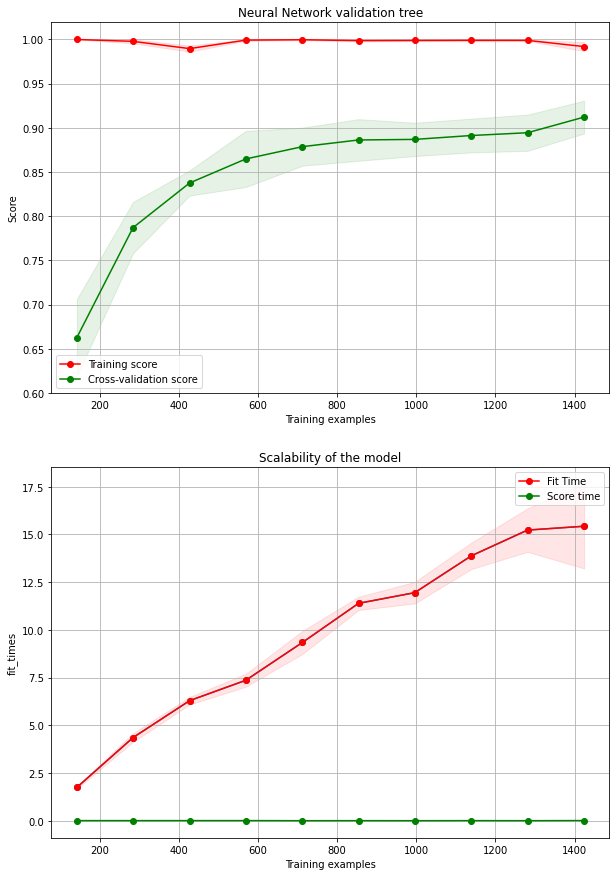

Neural Network hidden_layer_sizes: 60, learning_rate_init: 0.001


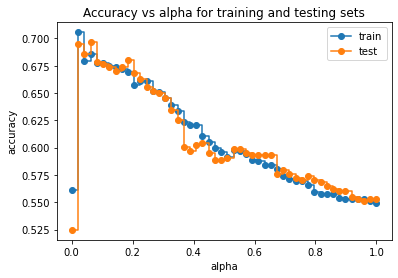

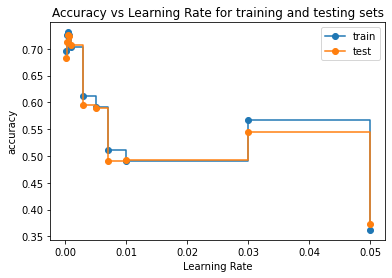

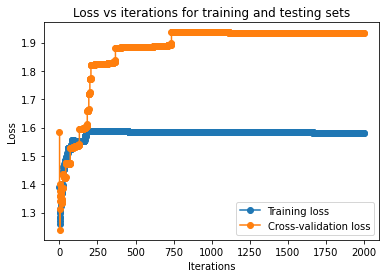

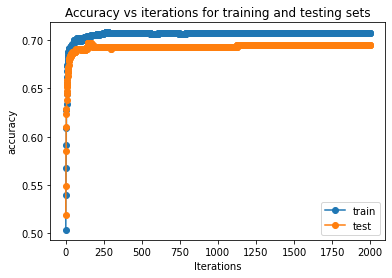

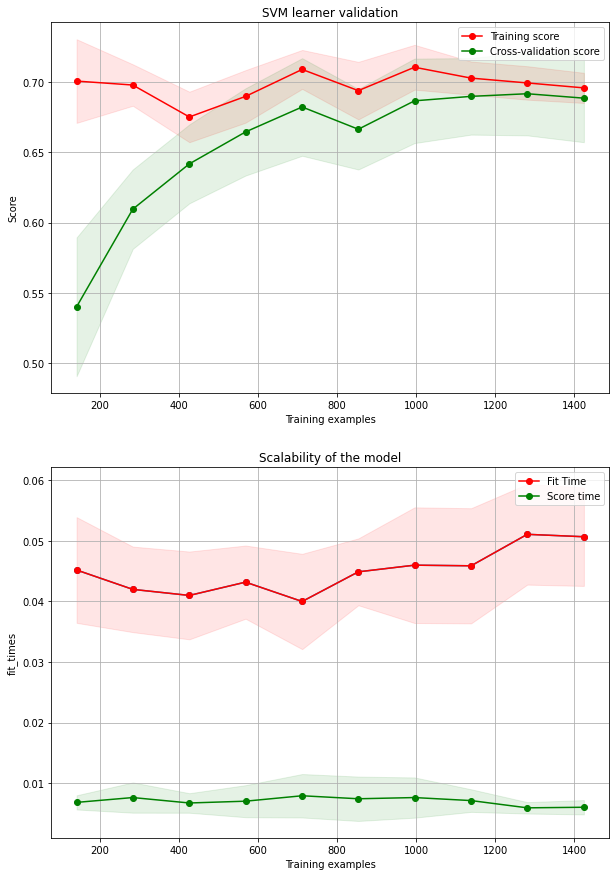

SVM alpha: 0.021387755102040818, Learning rate: 0.0003


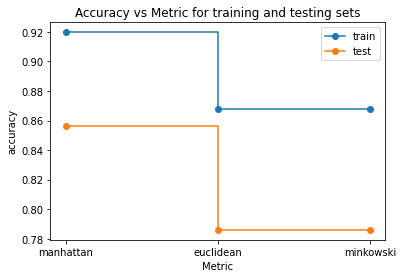

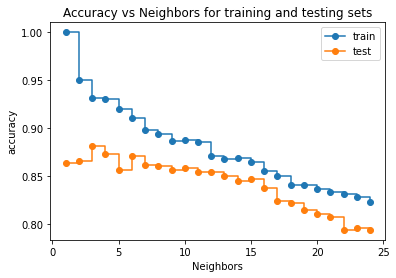

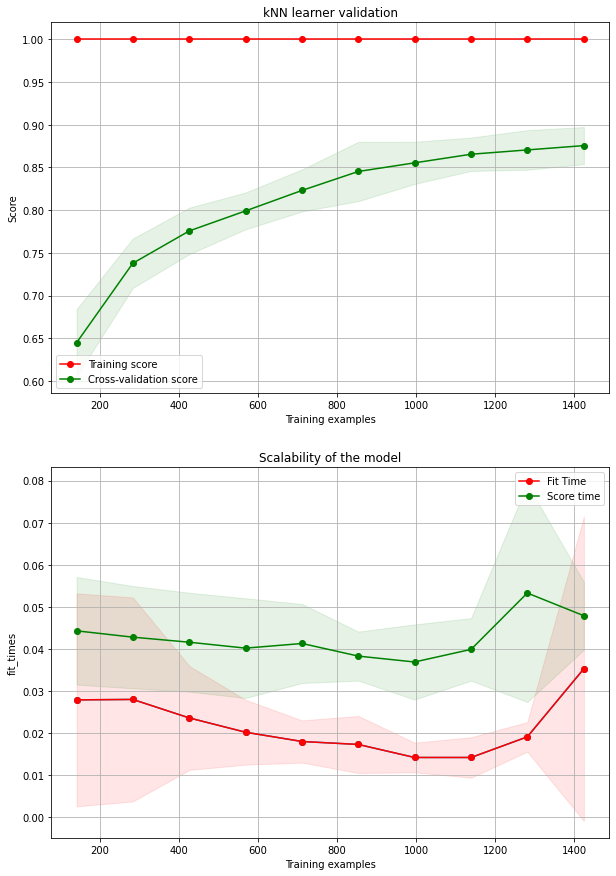

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


kNN metric: manhattan, n_neighbors: 1


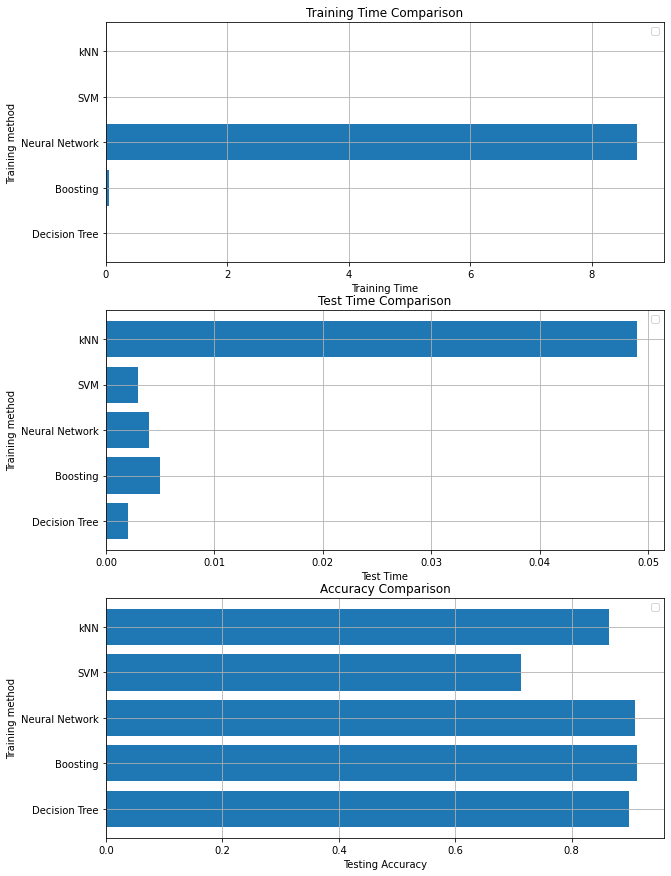

In [12]:
def convert_obseity_data(data):
    def genderToInt(gender):
        if (gender == 'Male'):
            return 1
        else:
            return 2
        
    def convert_yes_no_to_int(value):
        if (value == 'yes'):
            return 1
        else:
            return 0
        
    def convert_some_to_int(value):
        if (value == 'no'):
            return 0
        elif (value == 'Sometimes'):
            return 1
        elif (value == 'Frequently'):
            return 2
        elif (value == 'Always'):
            return 3
        
    def convert_transport_to_int(value):
        if (value == 'Walking'):
            return 0
        elif (value == 'Bike'):
            return 1
        elif (value == 'Public_Transportation'):
            return 2
        elif (value == 'Automobile'):
            return 3
        elif (value == 'Motorbike'):
            return 4
    
    def convert_obese_to_int(value):
        if (value == 'Insufficient_Weight'):
            return 0
        elif (value == 'Normal_Weight'):
            return 1
        elif (value == 'Overweight_Level_I'):
            return 2
        elif (value == 'Overweight_Level_II'):
            return 3
        elif (value == 'Obesity_Type_I'):
            return 4
        elif (value == 'Obesity_Type_II'):
            return 5
        elif (value == 'Obesity_Type_III'):
            return 6
        
    data['Gender'] = data['Gender'].transform(lambda x: genderToInt(x))
    data['Age'] = pd.cut(data['Age'].astype(float), bins=10, labels=np.arange(10))
    data['Height'] = pd.cut(data['Height'].astype(float), bins=10, labels=np.arange(10))
    data['Weight'] = pd.cut(data['Weight'].astype(float), bins=10, labels=np.arange(10))
    data['FCVC'] = pd.cut(data['FCVC'].astype(float), bins=8, labels=np.arange(8))
    data['NCP'] = pd.cut(data['NCP'].astype(float), bins=10, labels=np.arange(10))
    data['CH2O'] = pd.cut(data['CH2O'].astype(float), bins=8, labels=np.arange(8))
    data['FAF'] = pd.cut(data['FAF'].astype(float), bins=8, labels=np.arange(8))
    data['TUE'] = pd.cut(data['TUE'].astype(float), bins=8, labels=np.arange(8))
    data['family_history_with_overweight'] = data['family_history_with_overweight'].transform(lambda x: convert_yes_no_to_int(x))
    data['FAVC'] = data['FAVC'].transform(lambda x: convert_yes_no_to_int(x))
    data['CAEC'] = data['CAEC'].transform(lambda x: convert_some_to_int(x))
    data['SMOKE'] = data['SMOKE'].transform(lambda x: convert_yes_no_to_int(x))
    data['SCC'] = data['SCC'].transform(lambda x: convert_yes_no_to_int(x))
    data['CALC'] = data['CALC'].transform(lambda x: convert_some_to_int(x))
    data['MTRANS'] = data['MTRANS'].transform(lambda x: convert_transport_to_int(x))
    data['NObeyesdad'] = data['NObeyesdad'].transform(lambda x: convert_obese_to_int(x))
                           
    X = data[['Gender', 'Age','Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', "CAEC", "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"]]
    y = data[['NObeyesdad']]
    return X, y

def classify_obesity_data():
    train_times = np.empty(5)
    test_times = np.empty(5)
    accuracy = np.empty(5)
    df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv', delimiter=',')
    df = df[['Gender', 'Age','Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', "CAEC", "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS", "NObeyesdad"]]
    df = df.fillna(method="ffill")
    X, y = convert_obseity_data(df)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=random_state, shuffle=True)
    
    
    # Decision Tree
    ccp_alphas, criterion, max_depth, min_samples_leaf = classify_decision_tree(X_train, X_test, Y_train, Y_test)
    print("Decision tree ccp_alpha: " + str(ccp_alphas[0]) + ", criterion: " + str(criterion) + ", max_depth: " + str(max_depth) + ", min_samples_leaf: " + str(min_samples_leaf))
    
    clf = tree.DecisionTreeClassifier(random_state=random_state, criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, ccp_alpha=ccp_alphas[0])
    create_learning_curve(clf, X_train, Y_train, "Decision tree validation curves")
    clf = tree.DecisionTreeClassifier(random_state=random_state, criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, ccp_alpha=ccp_alphas[0])
    train_times[0], test_times[0], accuracy[0] = get_time_accuracy(clf,  X_train, X_test, Y_train, Y_test)
    
    # Boosting
    dclf = tree.DecisionTreeClassifier(random_state=random_state, criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, ccp_alpha=ccp_alphas[0])
    clf, n_estimators, learning_rate = classify_boosted_learner(dclf, X_train, X_test, Y_train, Y_test)
    train_times[1], test_times[1], accuracy[1] = get_time_accuracy(clf,  X_train, X_test, Y_train, Y_test)
    
    print("Boosted Learner n_estimators: " + str(n_estimators) + ", learning_rate: " + str(learning_rate))
    
    # Neural Network
    clf, hidden_layer_sizes, learning_rate_init = classify_neural_network(X_train, X_test, Y_train, Y_test, 2000)
    train_times[2], test_times[2], accuracy[2] = get_time_accuracy(clf,  X_train, X_test, Y_train, Y_test)
    
    print("Neural Network hidden_layer_sizes: " + str(hidden_layer_sizes) + ", learning_rate_init: " + str(learning_rate_init))
    
    # SVM
    clf, alpha, eta0 = classify_svm_learner(X_train, X_test, Y_train, Y_test)
    train_times[3], test_times[3], accuracy[3] = get_time_accuracy(clf,  X_train, X_test, Y_train, Y_test)
    
    print("SVM alpha: " + str(alpha) + ", Learning rate: " + str(eta0))
    
    # kNN
    clf, metric, n_neighbors = classify_kNN_learner(X_train, X_test, Y_train, Y_test)
    train_times[4], test_times[4], accuracy[4] = get_time_accuracy(clf,  X_train, X_test, Y_train, Y_test)
    print("kNN metric: " + str(metric) + ", n_neighbors: " + str(n_neighbors))
    
    plot_accuracy_time_comparison(train_times, test_times, accuracy)
    
classify_obesity_data()